In [75]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

# 1. Results B1.0

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [77]:
#B1.0
path_B1 = 'STRING_RESULT/B1.0/all_iterations_T0I1'

# Open all dataframes
S1 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B1}/all_iterations_string_T0_7917.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'STRING_RESULT/B1.0/all_iterations_T0/all_iterations_string_T0_3644.csv'

In [9]:
# Combine all dataframes into one
B1_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

,unique_id,text,RELEVANCE_x,llm_query,RELEVANCE_y,iteration
0,0,"Thank you, Mr. President .",Not relevant,"0 Thank you, Mr. President .\n",Not relevant,1
1,1,"On beha lf of the government of Japan , I wou...",Not relevant,"1 On beha lf of the government of Japan , I w...",Not relevant,1
2,2,I would also like to expr ess my d eepest con...,Not relevant,2 I would also like to expr ess my d eepest c...,Not relevant,1
3,3,Mr. President: A fair and effective framewor...,Relevant,3 Mr. President: A fair and effective framew...,Relevant,1
4,4,"In this regard, Japan firmly supports the est...",Statement of intent,"4 In this regard, Japan firmly supports the e...",Statement of intent,1
...,...,...,...,...,...,...
5815,1207,New Zealand is proud to suppor t several impo...,Not relevant,1207 New Zealand is proud to suppor t several...,Not relevant,1
5816,1208,"I am joined by New Zealand’s largest business,...",Not relevant,1208 I am joined by New Zealand’s largest busi...,Not relevant,1
5817,1209,The commitment o f New Zealanders from across ...,Not relevant,1209 The commitment o f New Zealanders from ac...,Not relevant,1
5818,1210,Thank you Mr President.,Not relevant,1210 Thank you Mr President.\n,Not relevant,1


In [37]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B1 = B1_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B1.shape

(4860, 6)

In [15]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B1['unique_id'].unique().tolist()

In [16]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [18]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'RELEVANCE_x', 'RELEVANCE_y')
report_S2 = generate_classification_report(FB1S2, 'RELEVANCE_x', 'RELEVANCE_y')
report_S3 = generate_classification_report(FB1S3, 'RELEVANCE_x', 'RELEVANCE_y')
report_S4 = generate_classification_report(FB1S4, 'RELEVANCE_x', 'RELEVANCE_y')
report_S5 = generate_classification_report(FB1S5, 'RELEVANCE_x', 'RELEVANCE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                     precision    recall  f1-score    support
Not relevant          0.955844  0.573209  0.716650  642.00000
Relevant              0.347395  0.818713  0.487805  171.00000
Statement of intent   0.472826  0.547170  0.507289  159.00000
accuracy              0.612140  0.612140  0.612140    0.61214
macro avg             0.592022  0.646364  0.570581  972.00000
weighted avg          0.769790  0.612140  0.642143  972.00000


Classification Report for S2
                     precision    recall  f1-score     support
Not relevant          0.955263  0.565421  0.710372  642.000000
Relevant              0.349127  0.818713  0.489510  171.000000
Statement of intent   0.460733  0.553459  0.502857  159.000000
accuracy              0.608025  0.608025  0.608025    0.608025
macro avg             0.588374  0.645864  0.567580  972.000000
weighted avg          0.767733  0.608025  0.637571  972.000000


Classification Report for S3
                     precision    

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [19]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['RELEVANCE_y'].nunique() != 1


# Group by 'ID' and filter groups
B1_consistency = filtered_B1.groupby('unique_id').filter(relevance_y_not_uniform)

B1_consistency

,unique_id,text,RELEVANCE_x,llm_query,RELEVANCE_y,iteration
46,46,These resources are affected by the negative i...,Not relevant,46 These resources are affected by the negativ...,Not relevant,1
47,47,It is for this reason that Namibia and Africa ...,Not relevant,47 It is for this reason that Namibia and Afri...,Statement of intent,1
49,49,Temperatures are rising at an alarming rate.,Not relevant,49 Temperatures are rising at an alarming rate.\n,Not relevant,1
57,57,Costs associated with adaptation efforts are a...,Not relevant,57 Costs associated with adaptation efforts ar...,Not relevant,1
101,101,"Mr. President, my delegation welcomes the furt...",Not relevant,"101 Mr. President, my delegation welcomes the ...",Not relevant,1
...,...,...,...,...,...,...
5762,1154,And as a country where refugees make up over ...,Not relevant,1154 And as a country where refugees make up ...,Statement of intent,1
5763,1155,This global initiative prioritises climate -re...,Not relevant,1155 This global initiative prioritises climat...,Relevant,1
5767,1159,"Today, Jordan’s most ambitious and vital proj...",Not relevant,"1159 Today, Jordan’s most ambitious and vital...",Statement of intent,1
5809,1201,And COP28 is our moment to act.,Not relevant,1201 And COP28 is our moment to act.\n,Statement of intent,1



In combined dataframe, groupyby unique ID and take the majority label

In [29]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B1.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'RELEVANCE_y']}
agg_dict['RELEVANCE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B1_grouped = filtered_B1.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B1_grouped

,unique_id,text,RELEVANCE_x,llm_query,iteration,RELEVANCE_y
0,20,Japan will establish a low carbon society thr...,Statement of intent,20 Japan will establish a low carbon society ...,1,Statement of intent
1,21,We will strategically promote mitigation meas...,Statement of intent,21 We will strategically promote mitigation m...,1,Statement of intent
2,22,We will enhance development and demonstration...,Statement of intent,22 We will enhance development and demonstrat...,1,Statement of intent
3,23,Japan is hosting the IPCC session next March.,Not relevant,23 Japan is hosting the IPCC session next Mar...,1,Not relevant
4,24,"Using that opportunity, we will launch a new ...",Statement of intent,"24 Using that opportunity, we will launch a n...",1,Statement of intent
...,...,...,...,...,...,...
967,1207,New Zealand is proud to suppor t several impo...,Not relevant,1207 New Zealand is proud to suppor t several...,1,Not relevant
968,1208,"I am joined by New Zealand’s largest business,...",Not relevant,1208 I am joined by New Zealand’s largest busi...,1,Not relevant
969,1209,The commitment o f New Zealanders from across ...,Not relevant,1209 The commitment o f New Zealanders from ac...,1,Not relevant
970,1210,Thank you Mr President.,Not relevant,1210 Thank you Mr President.\n,1,Not relevant


In [30]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B1_grouped['RELEVANCE_x'],filtered_B1_grouped['RELEVANCE_y']))

                     precision    recall  f1-score   support

       Not relevant       0.96      0.55      0.70       642
           Relevant       0.34      0.81      0.48       171
Statement of intent       0.46      0.56      0.51       159

           accuracy                           0.60       972
          macro avg       0.59      0.64      0.56       972
       weighted avg       0.77      0.60      0.63       972



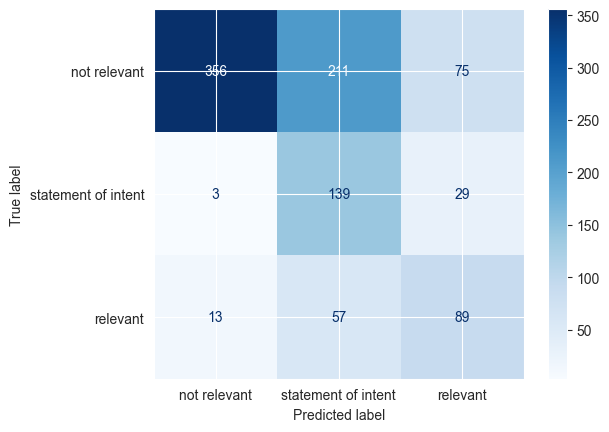

In [32]:
# Evaluate confusionmatrix for this aggregated set
labels = ['not relevant', 'statement of intent', 'relevant']

cm = confusion_matrix(filtered_B1_grouped['RELEVANCE_x'],filtered_B1_grouped['RELEVANCE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)


-------------------------------------------------------

# 2. Results B1.0.1

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [38]:
#B1.0
path_B101 = 'STRING_RESULT/B1.0.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B101}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B101}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B101}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B101}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B101}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B101_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [41]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B101 = B101_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B101.shape

(4700, 6)

In [42]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B101['unique_id'].unique().tolist()

In [43]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [44]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'RELEVANCE_x', 'RELEVANCE_y')
report_S2 = generate_classification_report(FB1S2, 'RELEVANCE_x', 'RELEVANCE_y')
report_S3 = generate_classification_report(FB1S3, 'RELEVANCE_x', 'RELEVANCE_y')
report_S4 = generate_classification_report(FB1S4, 'RELEVANCE_x', 'RELEVANCE_y')
report_S5 = generate_classification_report(FB1S5, 'RELEVANCE_x', 'RELEVANCE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                     precision    recall  f1-score     support
Not relevant          0.934579  0.499168  0.650759  601.000000
Relevant              0.321101  0.823529  0.462046  170.000000
Statement of intent   0.475410  0.514793  0.494318  169.000000
accuracy              0.560638  0.560638  0.560638    0.560638
macro avg             0.577030  0.612497  0.535708  940.000000
weighted avg          0.741078  0.560638  0.588504  940.000000


Classification Report for S2
                     precision    recall  f1-score     support
Not relevant          0.930380  0.489185  0.641221  601.000000
Relevant              0.312207  0.782353  0.446309  170.000000
Statement of intent   0.469697  0.550296  0.506812  169.000000
accuracy              0.553191  0.553191  0.553191    0.553191
macro avg             0.570761  0.607278  0.531447  940.000000
weighted avg          0.735758  0.553191  0.581806  940.000000


Classification Report for S3
                     precis

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [45]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['RELEVANCE_y'].nunique() != 1


# Group by 'ID' and filter groups
B101_consistency = filtered_B101.groupby('unique_id').filter(relevance_y_not_uniform)

B101_consistency

,unique_id,text,RELEVANCE_x,llm_query,RELEVANCE_y,iteration
8,8,Even under such circumstance both the public ...,Not relevant,8 Even under such circumstance both the publi...,Relevant,1
12,12,This target may appear to be less ambitious.,Not relevant,12 This target may appear to be less ambitiou...,Not relevant,1
65,65,Namibia believes that in order to achieve a co...,Relevant,65 Namibia believes that in order to achieve a...,Relevant,1
67,67,"This body, will bridge the scientific informat...",Not relevant,"67 This body, will bridge the scientific infor...",Not relevant,1
77,77,Climate change has no border; it affects all c...,Not relevant,77 Climate change has no border; it affects al...,Not relevant,1
...,...,...,...,...,...,...
5669,1073,Excellencies It is with great humility and hon...,Not relevant,1073 Excellencies It is with great humility an...,Not relevant,1
5670,1074,My government is aware of t he challenges pose...,Not relevant,1074 My government is aware of t he challenges...,Not relevant,1
5671,1075,"The theme of this event, "" climate transition ...",Not relevant,"1075 The theme of this event, "" climate transi...",Not relevant,1
5693,1097,Our NDC is ambitious enough to contribute our ...,Not relevant,1097 Our NDC is ambitious enough to contribute...,Statement of intent,1



In combined dataframe, groupyby unique ID and take the majority label

In [49]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B101.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'RELEVANCE_y']}
agg_dict['RELEVANCE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B101_grouped = filtered_B101.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B101_grouped

,unique_id,text,RELEVANCE_x,llm_query,iteration,RELEVANCE_y
0,0,"Thank you, Mr. President .",Not relevant,"0 Thank you, Mr. President .\n",1,Not relevant
1,1,"On beha lf of the government of Japan , I wou...",Not relevant,"1 On beha lf of the government of Japan , I w...",1,Not relevant
2,2,I would also like to expr ess my d eepest con...,Not relevant,2 I would also like to expr ess my d eepest c...,1,Not relevant
3,3,Mr. President: A fair and effective framewor...,Relevant,3 Mr. President: A fair and effective framew...,1,Relevant
4,4,"In this regard, Japan firmly supports the est...",Statement of intent,"4 In this regard, Japan firmly supports the e...",1,Statement of intent
...,...,...,...,...,...,...
935,1155,This global initiative prioritises climate -re...,Not relevant,1155 This global initiative prioritises climat...,1,Relevant
936,1156,We are grateful for the 58 countries that have...,Not relevant,1156 We are grateful for the 58 countries that...,1,Not relevant
937,1157,But much more needs to be done.,Statement of intent,1157 But much more needs to be done.\n,1,Statement of intent
938,1158,"My friends, Jordan contributes a slim 0.06 p...",Not relevant,"1158 My friends, Jordan contributes a slim 0...",1,Relevant


In [52]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B101_grouped['RELEVANCE_x'],filtered_B101_grouped['RELEVANCE_y']))

                     precision    recall  f1-score   support

       Not relevant       0.94      0.50      0.65       601
           Relevant       0.32      0.81      0.46       170
Statement of intent       0.46      0.52      0.49       169

           accuracy                           0.56       940
          macro avg       0.57      0.61      0.53       940
       weighted avg       0.74      0.56      0.59       940



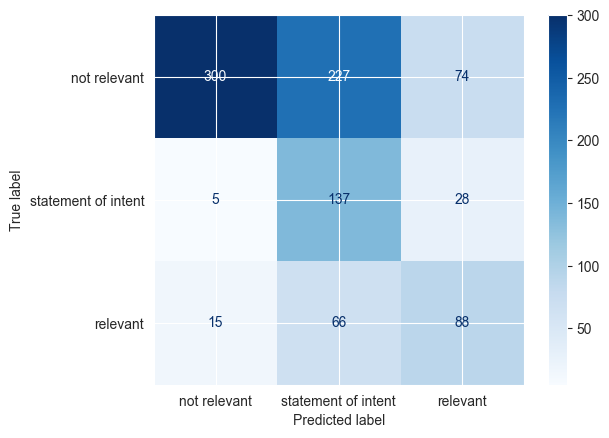

In [53]:
# Evaluate confusionmatrix for this aggregated set
labels = ['not relevant', 'statement of intent', 'relevant']

cm = confusion_matrix(filtered_B101_grouped['RELEVANCE_x'],filtered_B101_grouped['RELEVANCE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)


-------------------------------------------------------

# 3. Results B1.1

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [54]:
#B1.0
path_B11 = 'STRING_RESULT/B1.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B11}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B11}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B11}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B11}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B11}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B11_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [55]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B11 = B11_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B11.shape

(4300, 6)

In [56]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B11['unique_id'].unique().tolist()

In [57]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [58]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'RELEVANCE_x', 'RELEVANCE_y')
report_S2 = generate_classification_report(FB1S2, 'RELEVANCE_x', 'RELEVANCE_y')
report_S3 = generate_classification_report(FB1S3, 'RELEVANCE_x', 'RELEVANCE_y')
report_S4 = generate_classification_report(FB1S4, 'RELEVANCE_x', 'RELEVANCE_y')
report_S5 = generate_classification_report(FB1S5, 'RELEVANCE_x', 'RELEVANCE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                     precision    recall  f1-score     support
Not relevant          0.947090  0.615120  0.745833  582.000000
Relevant              0.372240  0.808219  0.509719  146.000000
Statement of intent   0.430303  0.537879  0.478114  132.000000
accuracy              0.636047  0.636047  0.636047    0.636047
macro avg             0.583211  0.653739  0.577889  860.000000
weighted avg          0.770178  0.636047  0.664657  860.000000


Classification Report for S2
                     precision    recall  f1-score     support
Not relevant          0.942105  0.615120  0.744283  582.000000
Relevant              0.375394  0.815068  0.514039  146.000000
Statement of intent   0.435583  0.537879  0.481356  132.000000
accuracy              0.637209  0.637209  0.637209    0.637209
macro avg             0.584361  0.656023  0.579893  860.000000
weighted avg          0.768151  0.637209  0.664839  860.000000


Classification Report for S3
                     precis

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [59]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['RELEVANCE_y'].nunique() != 1


# Group by 'ID' and filter groups
B11_consistency = filtered_B11.groupby('unique_id').filter(relevance_y_not_uniform)

B11_consistency

,unique_id,text,RELEVANCE_x,llm_query,RELEVANCE_y,iteration
47,47,It is for this reason that Namibia and Africa ...,Not relevant,47 It is for this reason that Namibia and Afri...,Statement of intent,1
95,95,This green growth Agenda is in line with low e...,Not relevant,95 This green growth Agenda is in line with lo...,Statement of intent,1
96,96,"In light of the above, I want to inform this g...",Not relevant,"96 In light of the above, I want to inform thi...",Relevant,1
140,140,"Our future generation will proud of us, if we ...",Relevant,"140 Our future generation will proud of us, if...",Statement of intent,1
145,145,"We arenot the masters of nature, but its stewa...",Not relevant,"145 We arenot the masters of nature, but its s...",Relevant,1
...,...,...,...,...,...,...
5522,1094,"In conclusion , let us remember that climate c...",Statement of intent,"1094 In conclusion , let us remember that clim...",Relevant,1
5561,1133,Climate Action Jamaica is not merely a specta...,Not relevant,1133 Climate Action Jamaica is not merely a s...,Relevant,1
5583,1155,This global initiative prioritises climate -re...,Not relevant,1155 This global initiative prioritises climat...,Statement of intent,1
5592,1164,"In other climate action, research at the Aqab...",Not relevant,"1164 In other climate action, research at the...",Statement of intent,1



In combined dataframe, groupyby unique ID and take the majority label

In [61]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B11.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'RELEVANCE_y']}
agg_dict['RELEVANCE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B11_grouped = filtered_B11.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B11_grouped

,unique_id,text,RELEVANCE_x,llm_query,iteration,RELEVANCE_y
0,40,Namibia stands side by side with the Philippin...,Not relevant,40 Namibia stands side by side with the Philip...,1,Not relevant
1,41,Namibia extends its warm appreciation to the G...,Not relevant,41 Namibia extends its warm appreciation to th...,1,Not relevant
2,42,We look forward to constructively engage and c...,Statement of intent,42 We look forward to constructively engage an...,1,Statement of intent
3,43,"Mr. President, COP19 has come and will soon pass.",Not relevant,"43 Mr. President, COP19 has come and will soon...",1,Not relevant
4,44,It should not only enable us to discuss global...,Relevant,44 It should not only enable us to discuss glo...,1,Relevant
...,...,...,...,...,...,...
855,1195,We’re also committed to collaborating with ou...,Not relevant,1195 We’re also committed to collaborating wi...,1,Statement of intent
856,1196,It is the number one secur ity threat to our r...,Not relevant,1196 It is the number one secur ity threat to ...,1,Relevant
857,1197,We back the 2050 strategy for the Blue Pacific...,Statement of intent,1197 We back the 2050 strategy for the Blue Pa...,1,Relevant
858,1198,We recognise that we must deliver on our coll...,Relevant,1198 We recognise that we must deliver on our...,1,Relevant


In [63]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B11_grouped['RELEVANCE_x'],filtered_B11_grouped['RELEVANCE_y']))

                     precision    recall  f1-score   support

       Not relevant       0.94      0.61      0.74       582
           Relevant       0.37      0.82      0.51       146
Statement of intent       0.43      0.52      0.47       132

           accuracy                           0.63       860
          macro avg       0.58      0.65      0.57       860
       weighted avg       0.77      0.63      0.66       860



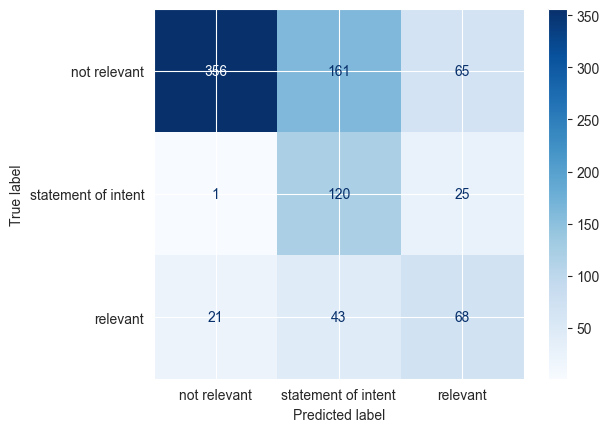

In [64]:
# Evaluate confusionmatrix for this aggregated set
labels = ['not relevant', 'statement of intent', 'relevant']

cm = confusion_matrix(filtered_B11_grouped['RELEVANCE_x'],filtered_B11_grouped['RELEVANCE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)


-------------------------------------------------------

# 4. Results B1.1.1

### 1. Import Results
Results created under the same fingerprint are saved in a CSV file for each seed. All results are combined into one dataset.

In [65]:
#B1.0
path_B111 = 'STRING_RESULT/B1.1.1/all_iterations'

# Open all dataframes
S1 = pd.read_csv(f'{path_B111}/all_iterations_string_T0_3644.csv')
S2 = pd.read_csv(f'{path_B111}/all_iterations_string_T0_3441.csv')
S3 = pd.read_csv(f'{path_B111}/all_iterations_string_T0_280.csv')
S4 = pd.read_csv(f'{path_B111}/all_iterations_string_T0_5991.csv')
S5 = pd.read_csv(f'{path_B111}/all_iterations_string_T0_7917.csv')

# Combine all dataframes into one
B111_full = pd.concat([S1, S2, S3, S4, S5], ignore_index=True)

In [66]:
# Filter rows to keep only those where the unique_id appears exactly 5 times
filtered_B111 = B111_full.groupby('unique_id').filter(lambda x: len(x) == 5)
filtered_B111.shape

(4760, 6)

In [67]:
# List of unique_id's that are annotated 5 times
unique_ids = filtered_B111['unique_id'].unique().tolist()

In [68]:
# Filter all original dataframes to only include sentences that are annotated 5x by other seeds
FB1S1 = S1[S1['unique_id'].isin(unique_ids)]
FB1S2 = S2[S2['unique_id'].isin(unique_ids)]
FB1S3 = S3[S3['unique_id'].isin(unique_ids)]
FB1S4 = S4[S4['unique_id'].isin(unique_ids)]
FB1S5 = S5[S5['unique_id'].isin(unique_ids)]

In [69]:
# Evaluate performance of individual seeds for the same sentences
# Function to generate classification report for each dataframe
def generate_classification_report(df, true_label_col, pred_label_col):
    return classification_report(df[true_label_col], df[pred_label_col], output_dict=True)

# Generate classification reports
report_S1 = generate_classification_report(FB1S1, 'RELEVANCE_x', 'RELEVANCE_y')
report_S2 = generate_classification_report(FB1S2, 'RELEVANCE_x', 'RELEVANCE_y')
report_S3 = generate_classification_report(FB1S3, 'RELEVANCE_x', 'RELEVANCE_y')
report_S4 = generate_classification_report(FB1S4, 'RELEVANCE_x', 'RELEVANCE_y')
report_S5 = generate_classification_report(FB1S5, 'RELEVANCE_x', 'RELEVANCE_y')

# Function to print the classification reports for easy comparison
def print_classification_report(report, title):
    print(f"Classification Report for {title}")
    print(pd.DataFrame(report).transpose())
    print("\n")

# Print the classification reports
print_classification_report(report_S1, "S1")
print_classification_report(report_S2, "S2")
print_classification_report(report_S3, "S3")
print_classification_report(report_S4, "S4")
print_classification_report(report_S5, "S5")

Classification Report for S1
                     precision    recall  f1-score     support
Not relevant          0.938830  0.575856  0.713852  613.000000
Relevant              0.343832  0.808642  0.482505  162.000000
Statement of intent   0.492308  0.542373  0.516129  177.000000
accuracy              0.609244  0.609244  0.609244    0.609244
macro avg             0.591657  0.642290  0.570829  952.000000
weighted avg          0.754561  0.609244  0.637723  952.000000


Classification Report for S2
                     precision    recall  f1-score     support
Not relevant          0.939633  0.584013  0.720322  613.000000
Relevant              0.352332  0.839506  0.496350  162.000000
Statement of intent   0.497297  0.519774  0.508287  177.000000
accuracy              0.615546  0.615546  0.615546    0.615546
macro avg             0.596420  0.647764  0.574987  952.000000
weighted avg          0.757452  0.615546  0.642787  952.000000


Classification Report for S3
                     precis

Evaluate consistency of predictions over the 5 different instances - see which sentences are not consistantly predicted.


In [70]:
# I want to evaluate consistency
# Print all rows where inconsequences are found per seed
# Define a function to check if all values in relevance_y are the same
def relevance_y_not_uniform(group):
    return group['RELEVANCE_y'].nunique() != 1


# Group by 'ID' and filter groups
B111_consistency = filtered_B111.groupby('unique_id').filter(relevance_y_not_uniform)

B111_consistency

,unique_id,text,RELEVANCE_x,llm_query,RELEVANCE_y,iteration
15,15,This is a target for the time being.,Not relevant,15 This is a target for the time being.\n,Statement of intent,1
28,28,"In this context, Japan’s public and private s...",Statement of intent,"28 In this context, Japan’s public and privat...",Not relevant,1
32,32,We will provide support to developing countri...,Statement of intent,32 We will provide support to developing coun...,Statement of intent,1
105,125,"We urge, all parties here in Warsaw to take de...",Relevant,"125 We urge, all parties here in Warsaw to tak...",Relevant,1
107,127,"In addition, all parties need to reaffirm thei...",Statement of intent,"127 In addition, all parties need to reaffirm ...",Statement of intent,1
...,...,...,...,...,...,...
5735,1187,And we are bracing ourselves for more fires th...,Not relevant,1187 And we are bracing ourselves for more fir...,Relevant,1
5738,1190,New Zealand has an ambitious NDC to reduce ne...,Not relevant,1190 New Zealand has an ambitious NDC to redu...,Statement of intent,1
5739,1191,"We are committed to achieving this, and our 20...",Statement of intent,"1191 We are committed to achieving this, and o...",Statement of intent,1
5748,1200,This is the time to move from words to action .,Not relevant,1200 This is the time to move from words to ac...,Statement of intent,1



In combined dataframe, groupyby unique ID and take the majority label

In [72]:
# Define a function to get the most frequent element
def most_frequent(x):
    return Counter(x).most_common(1)[0][0]

# List of all columns
all_columns = filtered_B111.columns.tolist()

# Dictionary to specify aggregation functions
agg_dict = {col: 'first' for col in all_columns if col not in ['unique_id', 'RELEVANCE_y']}
agg_dict['RELEVANCE_y'] = most_frequent

# Group by 'unique_id' and apply the aggregation functions
filtered_B111_grouped = filtered_B111.groupby('unique_id').agg(agg_dict).reset_index()

filtered_B111_grouped

,unique_id,text,RELEVANCE_x,llm_query,iteration,RELEVANCE_y
0,0,"Thank you, Mr. President .",Not relevant,"0 Thank you, Mr. President .\n",1,Not relevant
1,1,"On beha lf of the government of Japan , I wou...",Not relevant,"1 On beha lf of the government of Japan , I w...",1,Not relevant
2,2,I would also like to expr ess my d eepest con...,Not relevant,2 I would also like to expr ess my d eepest c...,1,Not relevant
3,3,Mr. President: A fair and effective framewor...,Relevant,3 Mr. President: A fair and effective framew...,1,Relevant
4,4,"In this regard, Japan firmly supports the est...",Statement of intent,"4 In this regard, Japan firmly supports the e...",1,Statement of intent
...,...,...,...,...,...,...
947,1207,New Zealand is proud to suppor t several impo...,Not relevant,1207 New Zealand is proud to suppor t several...,1,Not relevant
948,1208,"I am joined by New Zealand’s largest business,...",Not relevant,1208 I am joined by New Zealand’s largest busi...,1,Not relevant
949,1209,The commitment o f New Zealanders from across ...,Not relevant,1209 The commitment o f New Zealanders from ac...,1,Not relevant
950,1210,Thank you Mr President.,Not relevant,1210 Thank you Mr President.\n,1,Not relevant


In [73]:
# Evaluate performance of this dataframe
print(classification_report(filtered_B111_grouped['RELEVANCE_x'],filtered_B111_grouped['RELEVANCE_y']))

                     precision    recall  f1-score   support

       Not relevant       0.94      0.58      0.72       613
           Relevant       0.35      0.84      0.49       162
Statement of intent       0.51      0.54      0.53       177

           accuracy                           0.62       952
          macro avg       0.60      0.65      0.58       952
       weighted avg       0.76      0.62      0.64       952



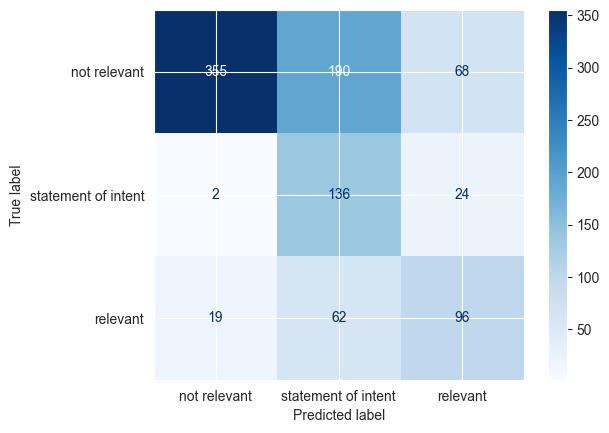

In [74]:
# Evaluate confusionmatrix for this aggregated set
labels = ['not relevant', 'statement of intent', 'relevant']

cm = confusion_matrix(filtered_B111_grouped['RELEVANCE_x'],filtered_B111_grouped['RELEVANCE_y'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
